## Автоматическое дифференцирование

In [ ]:
import torch
from torch import autograd

In [ ]:
x = torch.arange(4).type(torch.float)
print(x)

tensor([0., 1., 2., 3.])


## Присоединение градиента к `x`

- Говорит системе, что мы хотим хранить градиент

In [ ]:
x.requires_grad

False

In [ ]:
x = x.requires_grad_()

In [ ]:
x.requires_grad

True

In [ ]:
x.detach().requires_grad

False

In [ ]:
x.grad

## Forward

Вычислим

$$y = 2\mathbf{x}^{\top}\mathbf{x}$$

In [ ]:
y = 2 * x.dot(x.T)
y2 = 2 * x.dot(x.T)

<ipython-input-9-6d66b304b3a8>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  y = 2 * x.dot(x.T)


In [ ]:
y

tensor(28., grad_fn=<MulBackward0>)

## Backward

In [ ]:
y.backward()

## Получение градиента

$y = 2\mathbf{x}^{\top}\mathbf{x}$, значит

$$\frac{\partial y}{\partial \mathbf x} = 4\mathbf{x}$$

Проверим:

In [ ]:
x

tensor([0., 1., 2., 3.], requires_grad=True)

In [ ]:
x.grad

tensor([ 0.,  4.,  8., 12.])

In [ ]:
4 * x == x.grad

tensor([True, True, True, True])

## no_grad

Функция no_grad позволяет отключить вычисление градиента для части кода

In [ ]:
y = 2 * x.dot(x)
print(y.grad_fn)
with torch.no_grad():
    y = 2 * x.dot(x)
    print(y.grad_fn)

None


In [ ]:
x.grad

tensor([ 0.,  4.,  8., 12.])

In [ ]:
y = 2 * x.dot(x)
y.backward()
print(x.grad)
with torch.no_grad():
  y = 2 * x.dot(x)
  y.backward()
  print(x.grad)

tensor([ 0.,  8., 16., 24.])


RuntimeError: ignored

## Гибкий граф

In [ ]:
def f(a):
    b = a * 2
    while b.norm().item() < 1000:
        b = b * 2
    if b.sum().item() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [ ]:
a = torch.randn(1).requires_grad_()
d = f(a)
d.backward()

In [ ]:
d

tensor([1212.7317], grad_fn=<MulBackward0>)

In [ ]:
a

tensor([1.1843], requires_grad=True)

## Практика

1. Пусть $f(x) = \sin(x) * x$. Постройте график $f(x)$ и $\frac{df(x)}{dx}$ используя пакет autograd для расчёта производных (т.е. нельзя выводить производную явно)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
X = [w / 100.0 for w in range(-1000,1000,1)]

In [ ]:
Y = []
Y_der = []

In [ ]:
for x in X:
  xt = torch.Tensor((x,))
  xt.requires_grad_()
  y = torch.sin(xt) * xt
  y.backward()
  Y.append(y.item())
  Y_der.append(xt.grad.item())

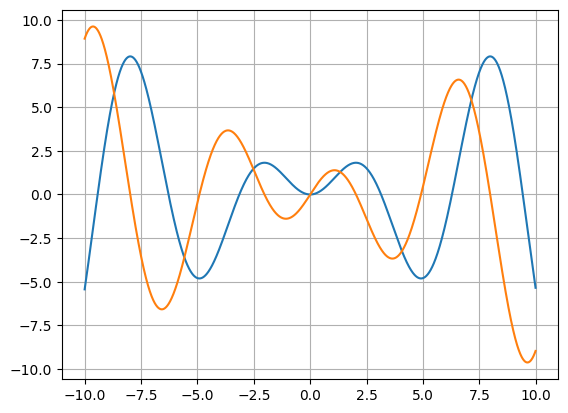

In [ ]:
plt.plot(X,Y)
plt.plot(X,Y_der)
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


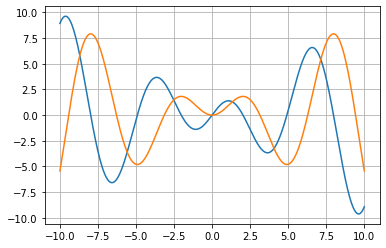

In [ ]:
import seaborn as sns
def f(x):
  return torch.sin(x)*x

x = torch.linspace(-10,10,1000).requires_grad_()
y = f(x)
y.backward(torch.ones_like(y))
dx = x.grad
sns.lineplot(x.detach().numpy(), dx)
sns.lineplot(x.detach().numpy(), y.detach().numpy())
plt.grid()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


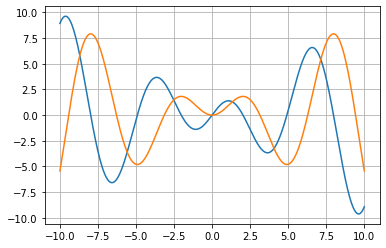

In [ ]:
import seaborn as sns
def f(x):
  return torch.sin(x)*x

x = torch.linspace(-10,10,1000).requires_grad_()
y = f(x)
y2 = y.sum()
y2.backward()
dx = x.grad
sns.lineplot(x.detach().numpy(), dx)
sns.lineplot(x.detach().numpy(), y.detach().numpy())
plt.grid()

## Линейная регрессия с нуля

In [ ]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import torch
import random

## Генерируем данные

- Случайно генерируем $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$
- Выбираем значения весов (истинные): $\mathbf{w} = [2, -3.4]^\top$ и свободного члена $b = 4.2$
- Генерируем метки по формле $\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$
  с шумом $\epsilon$ нормально распределённым с мат ожиданием 0 и дисперсией 1

In [ ]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features = torch.randn((num_examples, num_inputs))
labels = torch.mv(features, true_w) + true_b
labels += torch.randn(labels.shape)

## Визуализируем данные

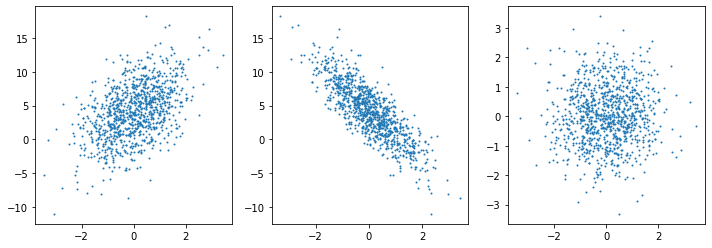

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(features[:, 0], labels, 1)
plt.subplot(132)
plt.scatter(features[:, 1], labels, 1)
plt.subplot(133)
plt.scatter(features[:, 0], features[:, 1], 1)
plt.show()


## Чтение данных

Итерируемся по датасету и возвращаем случайные `batch_size` примеры.

In [ ]:
import random

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = indices[i: min(i + batch_size, num_examples)]
        yield features[j, :], labels[j]

## Выводим маленький батч

In [ ]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X,'\n', y)
    break

tensor([[ 0.6414, -0.0140],
        [-0.2455, -0.6213],
        [-0.9405,  1.7354],
        [ 0.1481,  0.0426],
        [ 0.2203, -1.8093],
        [-0.1473, -1.0808],
        [-1.3825,  0.4214],
        [ 0.4227, -0.8688],
        [-1.1712, -0.9247],
        [ 0.4759, -0.4197]]) 
 tensor([ 4.7990,  7.8094, -4.0510,  2.3349, 11.1539,  6.8245,  0.0382,  8.4685,
         3.7750,  6.4771])


### Создаём модель для обучения

In [ ]:
w = torch.randn((num_inputs))
b = torch.zeros((1,))

In [ ]:
w.requires_grad_()
b.requires_grad_()

tensor([0.], requires_grad=True)

## Практика. Реализуйте функции:
- linreg - применение модели линейной регресии
- squared_loss - MSE функция потерь
- sgd - стохастический шаг градиентного спуска по массиву параметров

и допишите код обучения линейной регрессии

In [ ]:
def linreg(X, w, b):
  return torch.mv(X,w)+b

### Обучение

In [ ]:
def squared_loss(y_hat, y):
  return ((y_hat-y.reshape(y_hat.shape)) ** 2).mean()

In [ ]:
def sgd(params, lr):
  for param in params:
    param.data[:] = param - lr*param.grad


In [ ]:
lr = 0.01
num_epochs = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        w = w.detach()
        b = b.detach()
        w.requires_grad_()
        b.requires_grad_()

        l = squared_loss(linreg(X,w,b), y)
        l.backward()
        sgd([w,b], lr)
    train_l = squared_loss(linreg(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 1.462493
epoch 2, loss 0.952648
epoch 3, loss 0.932427
epoch 4, loss 0.931975
epoch 5, loss 0.932602
epoch 6, loss 0.934194
epoch 7, loss 0.932463
epoch 8, loss 0.932906
epoch 9, loss 0.931957
epoch 10, loss 0.931823


## Оценка качества модели

In [ ]:
print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)
print(w)
print(b)

Error in estimating w tensor([-0.0126, -0.0055], grad_fn=<SubBackward0>)
Error in estimating b tensor([-0.0225], grad_fn=<RsubBackward1>)
tensor([ 2.0126, -3.3945], requires_grad=True)
tensor([4.2225], requires_grad=True)


## Линейная регрессия на torch

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features = torch.randn((num_examples, num_inputs))
labels = torch.mv(features, true_w) + true_b
labels += torch.randn(labels.shape)

In [ ]:
features

tensor([[-0.0464,  0.3574],
        [ 1.1651, -0.8101],
        [ 0.7430,  0.2434],
        ...,
        [-0.3403,  0.6134],
        [-1.7471,  0.5546],
        [-0.0649, -0.2009]])

In [ ]:
features[0], labels[0]

(tensor([-0.0464,  0.3574]), tensor(5.3536))

In [ ]:
print(features.dtype), print(labels.dtype)

torch.float32
torch.float32


(None, None)

In [ ]:
for X, y in dataset:
    print(X, y)
    break

tensor([-0.0464,  0.3574]) tensor(5.3536)


In [ ]:
batch_size = 10
dataset = TensorDataset(features, labels)
# Randomly reading mini-batches
data_iter = DataLoader(dataset, batch_size, shuffle=True)

# Read a batch to see how it works
for X, y in data_iter:
    print(X, y)
    break

tensor([[ 0.6360, -0.1574],
        [ 0.0314, -0.9587],
        [ 1.6642,  0.8582],
        [ 0.2577,  0.1509],
        [-0.3090,  1.2851],
        [ 0.1885,  0.7631],
        [-0.0023,  0.9948],
        [ 0.2839, -0.2001],
        [-0.6791, -0.6949],
        [-0.3363, -1.1530]]) tensor([6.2090, 6.5999, 4.0875, 4.9593, 1.2782, 0.1584, 0.6036, 5.3337, 5.2315,
        8.2887])


In [ ]:
X * w + b

tensor([[ 4.2777,  1.1808],
        [ 3.9514,  6.1010],
        [ 2.6763,  3.4786],
        [ 4.6930,  3.9092],
        [ 5.5884,  1.2501],
        [ 6.2965,  0.2601],
        [ 2.2679, 10.3002],
        [ 5.3564, -0.6985],
        [ 0.3950,  1.4653],
        [ 2.4574,  1.5459]], grad_fn=<AddBackward0>)

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(2, 1))

In [ ]:
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

In [ ]:
model[0].weight.data = true_w.clone().detach().requires_grad_(True).reshape((1, 2))
model[0].bias.data = torch.tensor([true_b], requires_grad = True)

In [ ]:
loss = torch.nn.MSELoss(reduction='mean')

In [ ]:
trainer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
zzz = torch.tensor([[1.,2.],[3.,4.],[5.,6.]])

In [ ]:
labels.shape

torch.Size([1000])

In [ ]:
model(zzz).shape

torch.Size([3, 1])

In [ ]:
model(zzz).reshape(-1)

tensor([-1.5867, -3.9512, -6.3158], grad_fn=<ReshapeAliasBackward0>)

In [ ]:
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        trainer.zero_grad()
        l = loss(model(X).reshape(-1), y)
        l.backward()
        trainer.step()
    l = loss(model(features).reshape(-1), labels)
    if epoch % 5 == 0:
        print('epoch %d, loss: %f' % (epoch, l.item()),'|\tw', model[0].weight.data, '|\tb', model[0].bias.data)


epoch 5, loss: 4.882812 |	w tensor([[ 1.0015, -2.3883]]) |	b tensor([2.6789])
epoch 10, loss: 1.545528 |	w tensor([[ 1.5716, -3.0123]]) |	b tensor([3.5937])
epoch 15, loss: 1.066341 |	w tensor([[ 1.7897, -3.2420]]) |	b tensor([3.9433])
epoch 20, loss: 0.997042 |	w tensor([[ 1.8731, -3.3264]]) |	b tensor([4.0789])
epoch 25, loss: 0.987234 |	w tensor([[ 1.9050, -3.3572]]) |	b tensor([4.1300])
epoch 30, loss: 0.985825 |	w tensor([[ 1.9170, -3.3684]]) |	b tensor([4.1499])
epoch 35, loss: 0.985628 |	w tensor([[ 1.9215, -3.3718]]) |	b tensor([4.1578])
epoch 40, loss: 0.985599 |	w tensor([[ 1.9245, -3.3745]]) |	b tensor([4.1598])
epoch 45, loss: 0.985596 |	w tensor([[ 1.9252, -3.3749]]) |	b tensor([4.1614])
epoch 50, loss: 0.985597 |	w tensor([[ 1.9255, -3.3751]]) |	b tensor([4.1619])
epoch 55, loss: 0.985596 |	w tensor([[ 1.9254, -3.3746]]) |	b tensor([4.1612])
epoch 60, loss: 0.985597 |	w tensor([[ 1.9254, -3.3745]]) |	b tensor([4.1609])
epoch 65, loss: 0.985597 |	w tensor([[ 1.9251, -3.374

In [ ]:
w = model[0].weight.data
print('Error in estimating w', true_w.reshape(w.shape) - w)
b = model[0].bias.data
print('Error in estimating b', true_b - b)

Error in estimating w tensor([[-0.0492,  0.0096]])
Error in estimating b tensor([-0.0037])


In [ ]:
model[0].weight.data

tensor([[ 2.0492, -3.4096]])

In [ ]:
model[0].bias.data

tensor([4.2037])